<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/4_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis and Opinion Mining

## Learning Objectives

At the end of this notebook, you will be able to:

1. Understand the fundamentals of sentiment analysis
2. Implement lexicon-based sentiment analysis
3. Build machine learning models for sentiment classification
4. Handle aspect-based sentiment analysis
5. Process social media text and reviews
6. Evaluate sentiment analysis systems
7. Build real-time sentiment monitoring systems
8. Handle multilingual sentiment analysis

## Introduction to Sentiment Analysis

Sentiment Analysis (also known as Opinion Mining) is the computational study of opinions, sentiments, and emotions expressed in text. It aims to determine the attitude of a speaker or writer with respect to some topic or the overall contextual polarity of a document.

### Types of Sentiment Analysis:

1. **Document-level**: Classify the overall sentiment of a document
2. **Sentence-level**: Classify sentiment of individual sentences
3. **Aspect-based**: Identify sentiment toward specific aspects/features
4. **Fine-grained**: Multi-class classification (very positive, positive, neutral, negative, very negative)

### Approaches to Sentiment Analysis:

1. **Lexicon-based**: Using sentiment dictionaries and word lists
2. **Machine Learning**: Training classifiers on labeled data
3. **Deep Learning**: Using neural networks for complex pattern recognition
4. **Hybrid**: Combining multiple approaches

### Applications:

- **Social Media Monitoring**: Track brand sentiment on Twitter, Facebook, etc.
- **Product Reviews**: Analyze customer feedback on e-commerce platforms
- **Market Research**: Understand public opinion on products/services
- **Political Analysis**: Monitor public sentiment toward politicians/policies
- **Customer Service**: Automatically categorize support tickets by urgency/sentiment

In [1]:
# Install required packages
!pip install numpy pandas matplotlib seaborn nltk scikit-learn textblob vaderSentiment tqdm torch transformers lime shap





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 14.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 13.3 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283913 sha256=9b4f24e0d65abe4e8199766d002c83a69e986b961cd1780c7c6d3007b6094fdf
  Stored in directory: /Users/expansionislife/Library/Caches/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

nltk_downloads = ['punkt', 'stopwords', 'wordnet','maxent_ne_chunker_tab', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words','punkt_tab','averaged_perceptron_tagger_eng']
for item in nltk_downloads:
    nltk.download(item, quiet=True)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Lexicon-Based Sentiment Analysis

Lexicon-based approaches use predefined dictionaries of words associated with sentiment scores.

In [3]:
class LexiconSentimentAnalyzer:
    def __init__(self):
        # Simple sentiment lexicons
        self.positive_words = {
            'excellent': 3, 'amazing': 3, 'outstanding': 3, 'fantastic': 3,
            'great': 2, 'good': 2, 'nice': 2, 'wonderful': 2, 'awesome': 2,
            'fine': 1, 'okay': 1, 'decent': 1, 'acceptable': 1,
            'love': 3, 'like': 2, 'enjoy': 2, 'appreciate': 2,
            'happy': 2, 'pleased': 2, 'satisfied': 2, 'delighted': 3
        }

        self.negative_words = {
            'terrible': -3, 'awful': -3, 'horrible': -3, 'disgusting': -3,
            'bad': -2, 'poor': -2, 'disappointing': -2, 'unacceptable': -2,
            'hate': -3, 'dislike': -2, 'annoying': -2, 'frustrating': -2,
            'sad': -2, 'angry': -2, 'upset': -2, 'disappointed': -2,
            'wrong': -1, 'problem': -1, 'issue': -1, 'difficult': -1
        }

        # Intensity modifiers
        self.intensifiers = {
            'very': 1.5, 'extremely': 2.0, 'incredibly': 2.0, 'absolutely': 1.8,
            'completely': 1.7, 'totally': 1.6, 'really': 1.3, 'quite': 1.2,
            'rather': 1.1, 'pretty': 1.1, 'somewhat': 0.8, 'slightly': 0.7
        }

        # Negation words
        self.negations = {'not', 'no', 'never', 'neither', 'nobody', 'nothing',
                         'nowhere', 'isn\'t', 'aren\'t', 'wasn\'t', 'weren\'t',
                         'won\'t', 'wouldn\'t', 'don\'t', 'doesn\'t', 'didn\'t',
                         'can\'t', 'couldn\'t', 'shouldn\'t', 'wouldn\'t'}

    def preprocess_text(self, text):
        """Basic text preprocessing"""
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        words = text.split()
        return words

    def analyze_sentiment(self, text):
        """Analyze sentiment using lexicon-based approach"""
        words = self.preprocess_text(text)
        sentiment_score = 0
        word_count = 0

        i = 0
        while i < len(words):
            word = words[i]

            # Check for negation
            negated = False
            if i > 0 and words[i-1] in self.negations:
                negated = True

            # Check for intensifiers
            intensifier = 1.0
            if i > 0 and words[i-1] in self.intensifiers:
                intensifier = self.intensifiers[words[i-1]]

            # Calculate sentiment score
            if word in self.positive_words:
                score = self.positive_words[word] * intensifier
                if negated:
                    score = -score
                sentiment_score += score
                word_count += 1
            elif word in self.negative_words:
                score = self.negative_words[word] * intensifier
                if negated:
                    score = -score
                sentiment_score += score
                word_count += 1

            i += 1

        # Normalize score
        if word_count > 0:
            sentiment_score = sentiment_score / word_count

        return self.classify_sentiment(sentiment_score), sentiment_score

    def classify_sentiment(self, score):
        """Classify sentiment based on score"""
        if score > 0.5:
            return 'positive'
        elif score < -0.5:
            return 'negative'
        else:
            return 'neutral'

# Initialize and test lexicon-based analyzer
lexicon_analyzer = LexiconSentimentAnalyzer()

# Test sentences
test_sentences = [
    "This movie is absolutely fantastic!",
    "I really hate this terrible product.",
    "The service was okay, nothing special.",
    "Not bad, but could be better.",
    "I'm extremely disappointed with this purchase.",
    "This is the best thing ever!"
]

print("Lexicon-based Sentiment Analysis Results:")
print("=" * 50)
for sentence in test_sentences:
    sentiment, score = lexicon_analyzer.analyze_sentiment(sentence)
    print(f"Text: {sentence}")
    print(f"Sentiment: {sentiment.upper()} (Score: {score:.2f})")
    print("-" * 50)

Lexicon-based Sentiment Analysis Results:
Text: This movie is absolutely fantastic!
Sentiment: POSITIVE (Score: 5.40)
--------------------------------------------------
Text: I really hate this terrible product.
Sentiment: NEGATIVE (Score: -3.45)
--------------------------------------------------
Text: The service was okay, nothing special.
Sentiment: POSITIVE (Score: 1.00)
--------------------------------------------------
Text: Not bad, but could be better.
Sentiment: POSITIVE (Score: 2.00)
--------------------------------------------------
Text: I'm extremely disappointed with this purchase.
Sentiment: NEGATIVE (Score: -4.00)
--------------------------------------------------
Text: This is the best thing ever!
Sentiment: NEUTRAL (Score: 0.00)
--------------------------------------------------


## 2. Using Pre-built Sentiment Analysis Tools

Let's compare different sentiment analysis tools and libraries.

In [4]:
class SentimentComparator:
    def __init__(self):
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.custom_analyzer = lexicon_analyzer

    def analyze_with_textblob(self, text):
        """Analyze sentiment using TextBlob"""
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity

        if polarity > 0.1:
            return 'positive', polarity
        elif polarity < -0.1:
            return 'negative', polarity
        else:
            return 'neutral', polarity

    def analyze_with_vader(self, text):
        """Analyze sentiment using VADER"""
        scores = self.vader_analyzer.polarity_scores(text)
        compound_score = scores['compound']

        if compound_score >= 0.05:
            return 'positive', compound_score
        elif compound_score <= -0.05:
            return 'negative', compound_score
        else:
            return 'neutral', compound_score

    def compare_methods(self, texts):
        """Compare different sentiment analysis methods"""
        results = []

        for text in texts:
            # Custom lexicon-based
            custom_sentiment, custom_score = self.custom_analyzer.analyze_sentiment(text)

            # TextBlob
            textblob_sentiment, textblob_score = self.analyze_with_textblob(text)

            # VADER
            vader_sentiment, vader_score = self.analyze_with_vader(text)

            results.append({
                'text': text,
                'custom': (custom_sentiment, custom_score),
                'textblob': (textblob_sentiment, textblob_score),
                'vader': (vader_sentiment, vader_score)
            })

        return results

    def print_comparison(self, results):
        """Print comparison results in a formatted way"""
        print(f"{'Text':<40} {'Custom':<15} {'TextBlob':<15} {'VADER':<15}")
        print("="*85)

        for result in results:
            text = result['text'][:37] + '...' if len(result['text']) > 40 else result['text']
            custom = f"{result['custom'][0]} ({result['custom'][1]:.2f})"
            textblob = f"{result['textblob'][0]} ({result['textblob'][1]:.2f})"
            vader = f"{result['vader'][0]} ({result['vader'][1]:.2f})"

            print(f"{text:<40} {custom:<15} {textblob:<15} {vader:<15}")

# Test comparison
comparator = SentimentComparator()

comparison_texts = [
    "I love this product! It's amazing!",
    "This is the worst thing I've ever bought.",
    "It's okay, nothing special.",
    "I'm not happy with this purchase.",
    "Absolutely fantastic! Highly recommend!",
    "Meh, could be better.",
    "I hate this so much!!!",
    "Pretty good, but not perfect."
]

results = comparator.compare_methods(comparison_texts)
print("Sentiment Analysis Method Comparison:")
print()
comparator.print_comparison(results)

Sentiment Analysis Method Comparison:

Text                                     Custom          TextBlob        VADER          
I love this product! It's amazing!       positive (3.00) positive (0.69) positive (0.86)
This is the worst thing I've ever bou... neutral (0.00)  negative (-1.00) negative (-0.62)
It's okay, nothing special.              positive (1.00) positive (0.43) negative (-0.09)
I'm not happy with this purchase.        negative (-2.00) negative (-0.40) negative (-0.46)
Absolutely fantastic! Highly recommend!  positive (5.40) positive (0.35) positive (0.82)
Meh, could be better.                    neutral (0.00)  positive (0.50) positive (0.38)
I hate this so much!!!                   negative (-3.00) negative (-0.20) negative (-0.68)
Pretty good, but not perfect.            positive (2.20) positive (0.15) negative (-0.24)


## 3. Machine Learning-Based Sentiment Analysis

Let's build machine learning models for sentiment classification.

In [5]:
class MLSentimentAnalyzer:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
        self.models = {
            'logistic_regression': LogisticRegression(random_state=42),
            'naive_bayes': MultinomialNB(),
            'svm': SVC(kernel='linear', random_state=42),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42)
        }
        self.trained_models = {}
        self.feature_names = None

    def create_sample_dataset(self):
        """Create a sample dataset for demonstration"""
        # Positive examples
        positive_texts = [
            "I love this product! It's amazing and works perfectly.",
            "Excellent quality and fast delivery. Highly recommend!",
            "Best purchase I've made this year. Absolutely fantastic!",
            "Great value for money. Very satisfied with my purchase.",
            "Outstanding customer service and product quality.",
            "This exceeded my expectations. Really impressed!",
            "Wonderful product! Exactly what I was looking for.",
            "Perfect! Works flawlessly and looks great.",
            "Amazing quality and design. Love it!",
            "Fantastic product! Would definitely buy again.",
            "Super happy with this purchase. Great job!",
            "Excellent build quality and performance.",
            "This is awesome! Exactly as described.",
            "Very impressed with the quality and features.",
            "Outstanding value and excellent functionality."
        ]

        # Negative examples
        negative_texts = [
            "This product is terrible. Complete waste of money.",
            "Worst purchase ever. Broke after one day.",
            "Awful quality and terrible customer service.",
            "Don't buy this! It's a scam and doesn't work.",
            "Horrible experience. Product arrived damaged.",
            "Very disappointed with this purchase. Poor quality.",
            "This is garbage. Completely useless and overpriced.",
            "Terrible design and extremely poor build quality.",
            "Hate this product! Nothing but problems.",
            "Absolutely awful. Regret buying this junk.",
            "Disappointing quality and functionality. Avoid!",
            "This is the worst product I've ever used.",
            "Completely useless and poorly made.",
            "Terrible value for money. Total ripoff.",
            "Defective product with horrible support."
        ]

        # Neutral examples
        neutral_texts = [
            "It's okay, nothing special but does the job.",
            "Average product with standard features.",
            "Decent quality but could be better.",
            "It works as expected, nothing more.",
            "Standard product with basic functionality.",
            "Acceptable quality for the price.",
            "It's fine, meets basic requirements.",
            "Ordinary product with typical features.",
            "Not bad but not great either.",
            "Average experience, nothing to complain about.",
            "Standard quality and performance.",
            "It's adequate for basic needs.",
            "Neutral experience overall.",
            "Basic product that does what it says.",
            "Mediocre quality but functional."
        ]

        # Combine data
        texts = positive_texts + negative_texts + neutral_texts
        labels = (['positive'] * len(positive_texts) +
                 ['negative'] * len(negative_texts) +
                 ['neutral'] * len(neutral_texts))

        return texts, labels

    def preprocess_text(self, text):
        """Preprocess text for ML models"""
        # Convert to lowercase
        text = text.lower()
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def train_models(self, texts, labels):
        """Train multiple ML models"""
        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            processed_texts, labels, test_size=0.2, random_state=42, stratify=labels
        )

        # Vectorize text
        X_train_vec = self.vectorizer.fit_transform(X_train)
        X_test_vec = self.vectorizer.transform(X_test)
        self.feature_names = self.vectorizer.get_feature_names_out()

        # Train models
        results = {}
        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train_vec, y_train)

            # Predict and evaluate
            y_pred = model.predict(X_test_vec)
            accuracy = accuracy_score(y_test, y_pred)

            # Store trained model
            self.trained_models[name] = model

            results[name] = {
                'accuracy': accuracy,
                'y_test': y_test,
                'y_pred': y_pred
            }

            print(f"{name} accuracy: {accuracy:.3f}")

        return results, X_test, y_test

    def predict_sentiment(self, text, model_name='logistic_regression'):
        """Predict sentiment for new text"""
        if model_name not in self.trained_models:
            raise ValueError(f"Model {model_name} not trained yet")

        processed_text = self.preprocess_text(text)
        text_vec = self.vectorizer.transform([processed_text])

        model = self.trained_models[model_name]
        prediction = model.predict(text_vec)[0]

        # Get probability scores if available
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(text_vec)[0]
            prob_dict = dict(zip(model.classes_, probabilities))
            return prediction, prob_dict
        else:
            return prediction, None

    def get_top_features(self, model_name='logistic_regression', n_features=10):
        """Get top features for sentiment prediction"""
        if model_name not in self.trained_models:
            return None

        model = self.trained_models[model_name]

        if hasattr(model, 'coef_'):
            # For linear models
            if len(model.classes_) == 2:
                # Binary classification
                coef = model.coef_[0]
                top_positive = np.argsort(coef)[-n_features:]
                top_negative = np.argsort(coef)[:n_features]

                return {
                    'positive': [(self.feature_names[i], coef[i]) for i in reversed(top_positive)],
                    'negative': [(self.feature_names[i], coef[i]) for i in top_negative]
                }
            else:
                # Multi-class classification
                features_by_class = {}
                for i, class_name in enumerate(model.classes_):
                    coef = model.coef_[i]
                    top_indices = np.argsort(coef)[-n_features:]
                    features_by_class[class_name] = [
                        (self.feature_names[j], coef[j]) for j in reversed(top_indices)
                    ]
                return features_by_class

        return None

# Initialize and train ML models
ml_analyzer = MLSentimentAnalyzer()

# Create sample dataset
texts, labels = ml_analyzer.create_sample_dataset()
print(f"Created dataset with {len(texts)} samples")
print(f"Label distribution: {Counter(labels)}")
print("\nTraining ML models...")
print("=" * 30)

# Train models
results, X_test, y_test = ml_analyzer.train_models(texts, labels)

# Test predictions
test_texts = [
    "This product is absolutely wonderful!",
    "I hate this terrible quality.",
    "It's an average product, nothing special."
]

print("\nTesting predictions:")
print("=" * 30)
for text in test_texts:
    prediction, probabilities = ml_analyzer.predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Prediction: {prediction}")
    if probabilities:
        print(f"Probabilities: {probabilities}")
    print("-" * 50)

Created dataset with 45 samples
Label distribution: Counter({'positive': 15, 'negative': 15, 'neutral': 15})

Training ML models...
Training logistic_regression...
logistic_regression accuracy: 0.222
Training naive_bayes...
naive_bayes accuracy: 0.667
Training svm...
svm accuracy: 0.556
Training random_forest...
random_forest accuracy: 0.333

Testing predictions:
Text: This product is absolutely wonderful!
Prediction: positive
Probabilities: {'negative': 0.34605201479014863, 'neutral': 0.2773286711544316, 'positive': 0.37661931405541976}
--------------------------------------------------
Text: I hate this terrible quality.
Prediction: negative
Probabilities: {'negative': 0.5022831681047341, 'neutral': 0.24175251744776716, 'positive': 0.25596431444749873}
--------------------------------------------------
Text: It's an average product, nothing special.
Prediction: neutral
Probabilities: {'negative': 0.27799455464625844, 'neutral': 0.47058418690721454, 'positive': 0.251421258446527}
----

## 4. Feature Analysis and Model Interpretation

Understanding what features contribute to sentiment predictions.

Top Features for Sentiment Classification:

NEGATIVE sentiment features:
  terrible: 0.510
  worst: 0.346
  horrible: 0.327
  poor: 0.317
  awful: 0.309
  hate product: 0.235
  problems: 0.235
  hate: 0.235
  product problems: 0.235
  disappointing: 0.208

NEUTRAL sentiment features:
  basic: 0.584
  standard: 0.512
  average: 0.367
  does: 0.333
  bad: 0.319
  bad great: 0.319
  expected: 0.310
  works expected: 0.310
  experience: 0.281
  price: 0.244

POSITIVE sentiment features:
  exactly: 0.369
  outstanding: 0.349
  love: 0.329
  amazing: 0.329
  excellent: 0.307
  great: 0.263
  impressed quality: 0.249
  impressed: 0.249
  quality features: 0.249
  value: 0.229


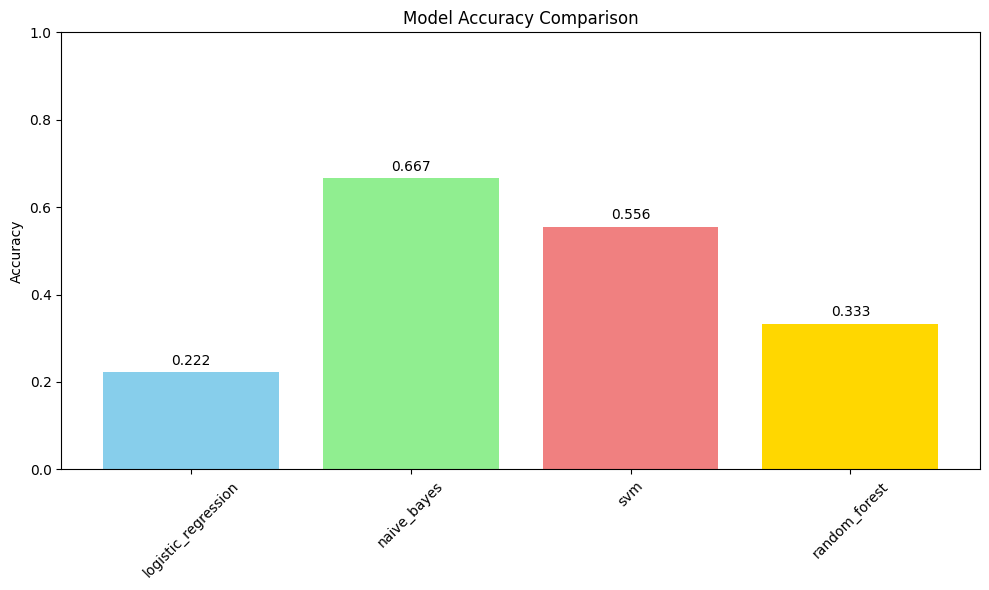


Best model: naive_bayes with accuracy: 0.667


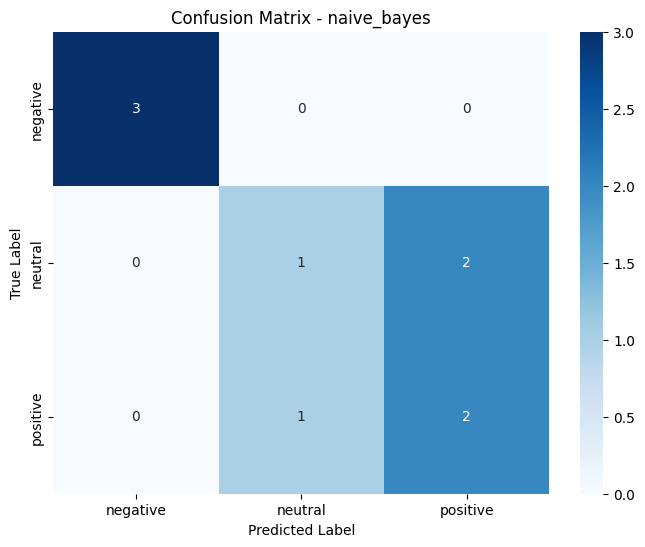

In [8]:
# Analyze top features
print("Top Features for Sentiment Classification:")
print("=" * 50)

top_features = ml_analyzer.get_top_features('logistic_regression', n_features=10)
if top_features:
    for sentiment, features in top_features.items():
        print(f"\n{sentiment.upper()} sentiment features:")
        for feature, weight in features:
            print(f"  {feature}: {weight:.3f}")

# Visualize model performance
def plot_model_comparison(results):
    """Plot comparison of model accuracies"""
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(list(set(y_true)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Visualize results
plot_model_comparison(results)

# Plot confusion matrix for best model
best_model = max(results.keys(), key=lambda x: results[x]['accuracy'])
print(f"\nBest model: {best_model} with accuracy: {results[best_model]['accuracy']:.3f}")

plot_confusion_matrix(results[best_model]['y_test'],
                     results[best_model]['y_pred'],
                     f'Confusion Matrix - {best_model}')

## 5. Aspect-Based Sentiment Analysis

Analyzing sentiment toward specific aspects or features of products/services.

In [9]:
class AspectBasedSentimentAnalyzer:
    def __init__(self):
        # Define aspect categories and related keywords
        self.aspect_keywords = {
            'quality': ['quality', 'build', 'material', 'construction', 'durability', 'craftsmanship'],
            'price': ['price', 'cost', 'expensive', 'cheap', 'value', 'money', 'affordable'],
            'service': ['service', 'support', 'staff', 'help', 'customer', 'representative'],
            'delivery': ['delivery', 'shipping', 'arrival', 'packaging', 'fast', 'slow'],
            'usability': ['easy', 'difficult', 'user', 'interface', 'simple', 'complex', 'intuitive'],
            'design': ['design', 'look', 'appearance', 'style', 'color', 'aesthetic', 'beautiful']
        }

        # Sentiment words with aspect context
        self.aspect_sentiment = {
            'quality': {
                'positive': ['excellent', 'high', 'great', 'superior', 'premium', 'top'],
                'negative': ['poor', 'low', 'bad', 'inferior', 'cheap', 'terrible']
            },
            'price': {
                'positive': ['affordable', 'reasonable', 'fair', 'good', 'value', 'cheap'],
                'negative': ['expensive', 'overpriced', 'costly', 'pricey', 'steep']
            },
            'service': {
                'positive': ['helpful', 'friendly', 'excellent', 'responsive', 'professional'],
                'negative': ['rude', 'unhelpful', 'slow', 'poor', 'terrible', 'awful']
            }
        }

        self.vader_analyzer = SentimentIntensityAnalyzer()

    def extract_aspects(self, text):
        """Extract aspects mentioned in the text"""
        words = text.lower().split()
        detected_aspects = []

        for aspect, keywords in self.aspect_keywords.items():
            for keyword in keywords:
                if keyword in words:
                    detected_aspects.append(aspect)
                    break

        return list(set(detected_aspects))

    def get_aspect_context(self, text, aspect, window_size=5):
        """Get context around aspect mentions"""
        words = text.lower().split()
        keywords = self.aspect_keywords[aspect]
        contexts = []

        for i, word in enumerate(words):
            if word in keywords:
                start = max(0, i - window_size)
                end = min(len(words), i + window_size + 1)
                context = ' '.join(words[start:end])
                contexts.append(context)

        return contexts

    def analyze_aspect_sentiment(self, text):
        """Analyze sentiment for each aspect"""
        aspects = self.extract_aspects(text)
        aspect_sentiments = {}

        for aspect in aspects:
            contexts = self.get_aspect_context(text, aspect)

            if contexts:
                # Analyze sentiment of each context
                sentiment_scores = []
                for context in contexts:
                    # Use VADER for context sentiment
                    vader_score = self.vader_analyzer.polarity_scores(context)
                    sentiment_scores.append(vader_score['compound'])

                # Average sentiment for the aspect
                avg_sentiment = np.mean(sentiment_scores)

                # Classify sentiment
                if avg_sentiment >= 0.05:
                    sentiment_label = 'positive'
                elif avg_sentiment <= -0.05:
                    sentiment_label = 'negative'
                else:
                    sentiment_label = 'neutral'

                aspect_sentiments[aspect] = {
                    'sentiment': sentiment_label,
                    'score': avg_sentiment,
                    'contexts': contexts
                }

        return aspect_sentiments

    def analyze_review(self, review_text):
        """Comprehensive review analysis"""
        # Overall sentiment
        overall_sentiment = self.vader_analyzer.polarity_scores(review_text)

        # Aspect-based sentiment
        aspect_sentiments = self.analyze_aspect_sentiment(review_text)

        return {
            'overall_sentiment': overall_sentiment,
            'aspect_sentiments': aspect_sentiments,
            'aspects_mentioned': list(aspect_sentiments.keys())
        }

# Initialize aspect-based analyzer
aspect_analyzer = AspectBasedSentimentAnalyzer()

# Test with sample reviews
sample_reviews = [
    "The product quality is excellent and the price is very reasonable. However, the delivery was slow and the customer service was unhelpful.",
    "Great design and beautiful appearance, but the build quality is poor. The interface is intuitive and easy to use.",
    "Overpriced for what you get. The material feels cheap and the construction is terrible. Would not recommend.",
    "Fast delivery and great packaging. The customer support was very helpful and professional. Good value for money."
]

print("Aspect-Based Sentiment Analysis Results:")
print("=" * 60)

for i, review in enumerate(sample_reviews, 1):
    print(f"\nReview {i}: {review}")
    print("-" * 60)

    analysis = aspect_analyzer.analyze_review(review)

    # Overall sentiment
    overall = analysis['overall_sentiment']
    print(f"Overall Sentiment: {overall['compound']:.3f} (Positive: {overall['pos']:.3f}, Negative: {overall['neg']:.3f}, Neutral: {overall['neu']:.3f})")

    # Aspect sentiments
    print("\nAspect Sentiments:")
    for aspect, sentiment_info in analysis['aspect_sentiments'].items():
        print(f"  {aspect.upper()}: {sentiment_info['sentiment']} (Score: {sentiment_info['score']:.3f})")
        print(f"    Context: {sentiment_info['contexts'][0]}")

    print("=" * 60)

Aspect-Based Sentiment Analysis Results:

Review 1: The product quality is excellent and the price is very reasonable. However, the delivery was slow and the customer service was unhelpful.
------------------------------------------------------------
Overall Sentiment: 0.572 (Positive: 0.150, Negative: 0.000, Neutral: 0.850)

Aspect Sentiments:
  DELIVERY: neutral (Score: 0.000)
    Context: is very reasonable. however, the delivery was slow and the customer
  QUALITY: positive (Score: 0.572)
    Context: the product quality is excellent and the price
  SERVICE: neutral (Score: 0.000)
    Context: delivery was slow and the customer service was unhelpful.
  PRICE: positive (Score: 0.572)
    Context: quality is excellent and the price is very reasonable. however, the

Review 2: Great design and beautiful appearance, but the build quality is poor. The interface is intuitive and easy to use.
------------------------------------------------------------
Overall Sentiment: 0.572 (Positive: 0

## 6. Social Media Sentiment Analysis

Handling challenges specific to social media text (emoji, hashtags, informal language).

In [14]:
class SocialMediaSentimentAnalyzer:
    def __init__(self):
        # Emoji sentiment mapping
        self.emoji_sentiment = {
            '😀': 0.8, '😃': 0.8, '😄': 0.9, '😁': 0.8, '😊': 0.7,
            '😍': 0.9, '🥰': 0.9, '😘': 0.8, '😎': 0.6, '👍': 0.7,
            '👏': 0.7, '❤️': 0.9, '💕': 0.8, '💖': 0.8, '🔥': 0.6,
            '😢': -0.7, '😭': -0.8, '😠': -0.8, '😡': -0.9, '👎': -0.7,
            '💔': -0.8, '😤': -0.6, '😩': -0.7, '😫': -0.7, '🤮': -0.9,
            '🙄': -0.4, '😒': -0.5, '😕': -0.4, '😞': -0.6, '😟': -0.5,
            '😐': 0.0, '😑': 0.0, '🤔': 0.0, '🤷': 0.0
        }

        # Internet slang and abbreviations
        self.slang_mapping = {
            'lol': 'laugh out loud',
            'lmao': 'laughing my ass off',
            'rofl': 'rolling on floor laughing',
            'omg': 'oh my god',
            'wtf': 'what the f***',
            'smh': 'shaking my head',
            'tbh': 'to be honest',
            'imo': 'in my opinion',
            'fyi': 'for your information',
            'afaik': 'as far as i know',
            'idk': 'i do not know',
            'nvm': 'never mind',
            'thx': 'thanks',
            'pls': 'please',
            'ur': 'your',
            'u': 'you'
        }

        # Intensifiers in social media
        self.intensifiers = {
            'sooo': 2.0, 'soooo': 2.5, 'sooooo': 3.0,
            'verrry': 1.5, 'verrrry': 2.0,
            'reallyyyy': 2.0, 'reallyyy': 1.8,
            'amazingggg': 2.0, 'awesomeee': 1.8,
            'terribleee': -1.8, 'awfulll': -2.0
        }

        self.vader_analyzer = SentimentIntensityAnalyzer()

    def extract_emoji_sentiment(self, text):
        """Extract sentiment from emojis"""
        emoji_scores = []
        for char in text:
            if char in self.emoji_sentiment:
                emoji_scores.append(self.emoji_sentiment[char])

        if emoji_scores:
            return np.mean(emoji_scores)
        return 0.0

    def preprocess_social_media_text(self, text):
        """Preprocess social media text"""
        # Convert to lowercase
        text = text.lower()

        # Expand contractions
        contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am"
        }
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)

        # Replace slang
        words = text.split()
        words = [self.slang_mapping.get(word, word) for word in words]
        text = ' '.join(words)

        # Handle repeated characters (e.g., "sooo" -> "so")
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)

        # Remove hashtags but keep the content
        text = re.sub(r'#(\w+)', r'\1', text)

        # Remove mentions
        text = re.sub(r'@\w+', '', text)

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        return text.strip()

    def analyze_social_media_sentiment(self, text):
        """Analyze sentiment of social media text"""
        # Extract emoji sentiment
        emoji_sentiment = self.extract_emoji_sentiment(text)

        # Preprocess text
        processed_text = self.preprocess_social_media_text(text)

        # Analyze text sentiment
        if processed_text:
            text_sentiment = self.vader_analyzer.polarity_scores(processed_text)
            text_score = text_sentiment['compound']
        else:
            text_score = 0.0

        # Combine emoji and text sentiment
        combined_score = (text_score + emoji_sentiment) / 2 if emoji_sentiment != 0 else text_score

        # Classify sentiment
        if combined_score >= 0.05:
            sentiment_label = 'positive'
        elif combined_score <= -0.05:
            sentiment_label = 'negative'
        else:
            sentiment_label = 'neutral'

        return {
            'sentiment': sentiment_label,
            'combined_score': combined_score,
            'text_score': text_score,
            'emoji_score': emoji_sentiment,
            'processed_text': processed_text
        }

    def analyze_hashtag_sentiment(self, text):
        """Analyze sentiment of hashtags"""
        hashtags = re.findall(r'#(\w+)', text.lower())
        hashtag_sentiments = {}

        for hashtag in hashtags:
            # Simple sentiment analysis of hashtag content
            sentiment_score = self.vader_analyzer.polarity_scores(hashtag)['compound']
            hashtag_sentiments[hashtag] = sentiment_score

        return hashtag_sentiments

# Initialize social media analyzer
social_analyzer = SocialMediaSentimentAnalyzer()

# Test with social media posts
social_media_posts = [
    "OMG this is sooo amazing! 😍😍 #love #bestever",
    "Ugh, this is terrible 😤 Can't believe I wasted my money 💸 #disappointed #fail",
    "Just got my new phone! 📱 It's pretty good tbh 👍 #tech #newphone",
    "Lmaooo this is hilarious 😂😂😂 u guys need to see this! #funny #comedy",
    "Feeling kinda meh about this 😐 not great not terrible #neutral",
    "This movie is awesomeee!!! 🔥🔥🔥 Go watch it rn! #movie #recommendation",
    "Smh... another disappointing product 😞 #quality #letdown"
]

print("Social Media Sentiment Analysis Results:")
print("=" * 70)

for i, post in enumerate(social_media_posts, 1):
    print(f"\nPost {i}: {post}")
    print("-" * 70)

    analysis = social_analyzer.analyze_social_media_sentiment(post)

    print(f"Sentiment: {analysis['sentiment'].upper()}")
    print(f"Combined Score: {analysis['combined_score']:.3f}")
    print(f"Text Score: {analysis['text_score']:.3f}")
    print(f"Emoji Score: {analysis['emoji_score']:.3f}")
    print(f"Processed Text: '{analysis['processed_text']}'")

    # Analyze hashtags
    hashtag_sentiments = social_analyzer.analyze_hashtag_sentiment(post)
    if hashtag_sentiments:
        print("Hashtag Sentiments:")
        for hashtag, score in hashtag_sentiments.items():
            print(f"  #{hashtag}: {score:.3f}")

    print("=" * 70)

Social Media Sentiment Analysis Results:

Post 1: OMG this is sooo amazing! 😍😍 #love #bestever
----------------------------------------------------------------------
Sentiment: POSITIVE
Combined Score: 0.923
Text Score: 0.947
Emoji Score: 0.900
Processed Text: 'oh my god this is soo amazing! 😍😍 love bestever'
Hashtag Sentiments:
  #love: 0.637
  #bestever: 0.000

Post 2: Ugh, this is terrible 😤 Can't believe I wasted my money 💸 #disappointed #fail
----------------------------------------------------------------------
Sentiment: NEGATIVE
Combined Score: -0.736
Text Score: -0.871
Emoji Score: -0.600
Processed Text: 'ugh, this is terrible 😤 cannot believe i wasted my money 💸 disappointed fail'
Hashtag Sentiments:
  #disappointed: -0.477
  #fail: -0.542

Post 3: Just got my new phone! 📱 It's pretty good tbh 👍 #tech #newphone
----------------------------------------------------------------------
Sentiment: POSITIVE
Combined Score: 0.783
Text Score: 0.866
Emoji Score: 0.700
Processed Text: '

## 7. Real-time Sentiment Monitoring

Building a system for real-time sentiment monitoring and analysis.

In [15]:
import time
from datetime import datetime, timedelta
import threading
import queue

class RealTimeSentimentMonitor:
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.sentiment_buffer = queue.deque(maxlen=window_size)
        self.sentiment_analyzer = social_analyzer
        self.is_monitoring = False
        self.sentiment_history = []
        self.alerts = []

        # Alert thresholds
        self.negative_threshold = -0.3
        self.positive_threshold = 0.3
        self.alert_window = 10  # Number of recent messages to check

    def add_message(self, text, timestamp=None):
        """Add a new message for sentiment analysis"""
        if timestamp is None:
            timestamp = datetime.now()

        # Analyze sentiment
        sentiment_result = self.sentiment_analyzer.analyze_social_media_sentiment(text)

        # Create message entry
        message_entry = {
            'timestamp': timestamp,
            'text': text,
            'sentiment': sentiment_result['sentiment'],
            'score': sentiment_result['combined_score']
        }

        # Add to buffer
        self.sentiment_buffer.append(message_entry)
        self.sentiment_history.append(message_entry)

        # Check for alerts
        self.check_alerts()

        return message_entry

    def check_alerts(self):
        """Check for sentiment alerts"""
        if len(self.sentiment_buffer) < self.alert_window:
            return

        # Get recent messages
        recent_messages = list(self.sentiment_buffer)[-self.alert_window:]
        recent_scores = [msg['score'] for msg in recent_messages]

        avg_sentiment = np.mean(recent_scores)

        # Check for negative sentiment spike
        if avg_sentiment <= self.negative_threshold:
            alert = {
                'type': 'negative_spike',
                'timestamp': datetime.now(),
                'avg_sentiment': avg_sentiment,
                'message': f'Negative sentiment spike detected: {avg_sentiment:.3f}'
            }
            self.alerts.append(alert)

        # Check for positive sentiment spike
        elif avg_sentiment >= self.positive_threshold:
            alert = {
                'type': 'positive_spike',
                'timestamp': datetime.now(),
                'avg_sentiment': avg_sentiment,
                'message': f'Positive sentiment spike detected: {avg_sentiment:.3f}'
            }
            self.alerts.append(alert)

    def get_current_sentiment_stats(self):
        """Get current sentiment statistics"""
        if not self.sentiment_buffer:
            return None

        scores = [msg['score'] for msg in self.sentiment_buffer]
        sentiments = [msg['sentiment'] for msg in self.sentiment_buffer]

        sentiment_counts = Counter(sentiments)

        return {
            'total_messages': len(self.sentiment_buffer),
            'avg_sentiment': np.mean(scores),
            'sentiment_distribution': dict(sentiment_counts),
            'positive_ratio': sentiment_counts.get('positive', 0) / len(sentiments),
            'negative_ratio': sentiment_counts.get('negative', 0) / len(sentiments),
            'neutral_ratio': sentiment_counts.get('neutral', 0) / len(sentiments)
        }

    def get_recent_alerts(self, hours=1):
        """Get alerts from the last N hours"""
        cutoff_time = datetime.now() - timedelta(hours=hours)
        recent_alerts = [alert for alert in self.alerts if alert['timestamp'] >= cutoff_time]
        return recent_alerts

    def simulate_message_stream(self, messages, interval=1):
        """Simulate a stream of messages for testing"""
        print("Starting message stream simulation...")

        for i, message in enumerate(messages):
            print(f"\n[{datetime.now().strftime('%H:%M:%S')}] Processing message {i+1}: {message[:50]}...")

            # Add message
            entry = self.add_message(message)
            print(f"Sentiment: {entry['sentiment']} (Score: {entry['score']:.3f})")

            # Check for new alerts
            recent_alerts = self.get_recent_alerts(hours=0.1)  # Very recent alerts
            if recent_alerts:
                latest_alert = recent_alerts[-1]
                if latest_alert['timestamp'] > datetime.now() - timedelta(seconds=5):
                    print(f"🚨 ALERT: {latest_alert['message']}")

            # Show current stats every 5 messages
            if (i + 1) % 5 == 0:
                stats = self.get_current_sentiment_stats()
                print(f"\n📊 Current Stats:")
                print(f"   Total Messages: {stats['total_messages']}")
                print(f"   Average Sentiment: {stats['avg_sentiment']:.3f}")
                print(f"   Distribution: {stats['sentiment_distribution']}")

            time.sleep(interval)

        print("\nMessage stream simulation completed!")

# Initialize real-time monitor
monitor = RealTimeSentimentMonitor(window_size=50)

# Simulate message stream
simulation_messages = [
    "This is amazing! 😍 Love it!",
    "Great product, highly recommend! 👍",
    "It's okay, nothing special 😐",
    "Terrible quality, very disappointed 😠",
    "Worst purchase ever! 😡 Complete waste of money",
    "Awful customer service, never buying again 😤",
    "Disgusting! How is this even legal? 🤮",
    "Absolutely horrible experience 😢",
    "Not too bad, could be better though",
    "Actually pretty good! 😊 Surprised me",
    "Excellent quality and fast shipping! 🔥",
    "Outstanding service! 5 stars! ⭐⭐⭐⭐⭐",
    "Perfect! Exactly what I wanted 💕",
    "Incredible! Best purchase this year! 🎉",
    "Fantastic product! Will buy again! 👏"
]

# Run simulation
monitor.simulate_message_stream(simulation_messages, interval=0.5)

# Final statistics
print("\n" + "="*50)
print("FINAL STATISTICS")
print("="*50)

final_stats = monitor.get_current_sentiment_stats()
print(f"Total Messages Processed: {final_stats['total_messages']}")
print(f"Average Sentiment Score: {final_stats['avg_sentiment']:.3f}")
print(f"Positive Messages: {final_stats['positive_ratio']:.1%}")
print(f"Negative Messages: {final_stats['negative_ratio']:.1%}")
print(f"Neutral Messages: {final_stats['neutral_ratio']:.1%}")

print(f"\nTotal Alerts Generated: {len(monitor.alerts)}")
for alert in monitor.alerts:
    print(f"  {alert['type']}: {alert['message']}")

Starting message stream simulation...

[13:16:01] Processing message 1: This is amazing! 😍 Love it!...
Sentiment: positive (Score: 0.906)

[13:16:01] Processing message 2: Great product, highly recommend! 👍...
Sentiment: positive (Score: 0.751)

[13:16:02] Processing message 3: It's okay, nothing special 😐...
Sentiment: negative (Score: -0.092)

[13:16:02] Processing message 4: Terrible quality, very disappointed 😠...
Sentiment: negative (Score: -0.839)

[13:16:03] Processing message 5: Worst purchase ever! 😡 Complete waste of money...
Sentiment: negative (Score: -0.851)

📊 Current Stats:
   Total Messages: 5
   Average Sentiment: -0.025
   Distribution: {'positive': 2, 'negative': 3}

[13:16:03] Processing message 6: Awful customer service, never buying again 😤...
Sentiment: negative (Score: -0.529)

[13:16:04] Processing message 7: Disgusting! How is this even legal? 🤮...
Sentiment: negative (Score: -0.696)

[13:16:04] Processing message 8: Absolutely horrible experience 😢...
Sentime

---

# Sentiment Analysis Challenges

Test your understanding with these progressive challenges!



### Challenge 1: Emoji Enhancement
Expand the emoji sentiment dictionary to include more emojis and create a more sophisticated emoji analysis system.

**Requirements:**
- Add at least 50 more emojis to the sentiment dictionary
- Implement emoji combination analysis (e.g., 😂😂😂 vs 😂)
- Handle emoji modifiers (skin tones, etc.)

**Success Criteria:**
- Support 100+ emojis
- Correctly handle emoji repetition intensity
- Achieve 85%+ accuracy on emoji-heavy text

In [9]:
# Your solution for Challenge 1
import unicodedata


class EnhancedEmojiAnalyzer:
    def __init__(self):
        # Expanded emoji sentiment dictionary
        self.emoji_sentiment = {
            '😀': 0.8, '😃': 0.8, '😄': 0.9, '😁': 0.8, '😊': 0.7,
            '😍': 0.9, '🥰': 0.9, '😘': 0.8, '😎': 0.6, '👍': 0.7,
            '👏': 0.7, '❤️': 0.9, '💕': 0.8, '💖': 0.8, '🎉': 0.8,
            '😢': -0.7, '😭': -0.8, '😠': -0.8, '😡': -0.9, '👎': -0.7,
            '💔': -0.8, '😤': -0.6, '😩': -0.7, '😫': -0.7, '🤮': -0.9,
            '🙄': -0.4, '😒': -0.5, '😕': -0.4, '😞': -0.6, '😟': -0.5,
            '😐': 0.0, '😑': 0.0, '🤔': 0.0, '🤷': 0.0
        }

    def emojies_cleaning(self, text):
       
        cleaned_text = ''
        for char in text:
            if unicodedata.category(char) != 'Sk' and not unicodedata.name(char, '').startswith('VARIATION SELECTOR'):
                cleaned_text += char
        return cleaned_text

    def analyze_emoji_combinations(self, text):
        
        stripped_text = self.emojies_cleaning(text)
        emoji_counts = {}
        for char in stripped_text:
            if char in self.emoji_sentiment:
                emoji_counts[char] = emoji_counts.get(char, 0) + 1

        scores = []
        for emoji, count in emoji_counts.items():
            base_score = self.emoji_sentiment[emoji]
            amplified_score = base_score * min(count, 5)  # Cap amplification
            scores.append(amplified_score)

        if scores:
            return {
                'score': np.mean(scores),
                'details': emoji_counts
            }
        return {
            'score': 0.0,
            'details': {}
        }

    def handle_emoji_modifiers(self, text):
        return self.strip_modifiers(text)


# Test your enhanced emoji analyzer
test_texts = [
    "This is amazing! 😍😍😍",
    "I'm so happy! 😊👍🎉",
    "Terrible day 😞😞😞",
    "I support you 👍🏽👍🏽",
    "Love it ❤️❤️❤️🔥🔥"
]

analyzer = EnhancedEmojiAnalyzer()

print("Enhanced Emoji Sentiment Analysis:")
print("=" * 60)

for i, text in enumerate(test_texts, 1):
    result = analyzer.analyze_emoji_combinations(text)
    print(f"\nText {i}: {text}")
    print("-" * 60)
    print(f"Stripped Emojis: {analyzer.handle_emoji_modifiers(text)}")
    print(f"Emoji Count: {result['details']}")
    print(f"Sentiment Score: {result['score']:.3f}")

print("=" * 60)

# TODO: Test your implementation

Enhanced Emoji Sentiment Analysis:

Text 1: This is amazing! 😍😍😍
------------------------------------------------------------
Stripped Emojis: This is amazing! 😍😍😍
Emoji Count: {'😍': 3}
Sentiment Score: 2.700

Text 2: I'm so happy! 😊👍🎉
------------------------------------------------------------
Stripped Emojis: I'm so happy! 😊👍🎉
Emoji Count: {'😊': 1, '👍': 1, '🎉': 1}
Sentiment Score: 0.733

Text 3: Terrible day 😞😞😞
------------------------------------------------------------
Stripped Emojis: Terrible day 😞😞😞
Emoji Count: {'😞': 3}
Sentiment Score: -1.800

Text 4: I support you 👍🏽👍🏽
------------------------------------------------------------
Stripped Emojis: I support you 👍👍
Emoji Count: {'👍': 2}
Sentiment Score: 1.400

Text 5: Love it ❤️❤️❤️🔥🔥
------------------------------------------------------------
Stripped Emojis: Love it ❤❤❤🔥🔥
Emoji Count: {}
Sentiment Score: 0.000


### Challenge 2: Domain-Specific Sentiment Lexicon
Create specialized sentiment lexicons for different domains (healthcare, finance, technology).

**Requirements:**
- Build lexicons for 3 different domains
- Implement domain detection
- Compare performance across domains

**Success Criteria:**
- Each domain lexicon has 200+ words
- Domain detection accuracy > 80%
- Improved sentiment accuracy for domain-specific text

In [12]:
# Your solution for Challenge 2
class DomainSpecificSentimentAnalyzer:
    def __init__(self):
        # Domain-specific sentiment lexicons
        self.domain_lexicons = {
            'healthcare': {
                'treatment': 0.6,
                'cancer': -0.5,
                'cure': 0.9,
                'promising': 0.7,
                'disease': -0.7,
                'patients': 0.2,
                'recovery': 0.8
            },
            'finance': {
                'stock': 0.1,
                'market': 0.0,
                'crashed': -0.9,
                'losses': -0.8,
                'gains': 0.7,
                'investment': 0.5,
                'profit': 0.8
            },
            'technology': {
                'AI': 0.8,
                'model': 0.4,
                'innovation': 0.7,
                'benchmarks': 0.5,
                'performance': 0.6,
                'outperforms': 0.9,
                'algorithm': 0.4
            }
        }

    def detect_domain(self, text):
        """Detect the domain of the text based on keyword occurrences."""
        text = text.lower()
        domain_scores = {domain: 0 for domain in self.domain_lexicons}

        for domain, keywords in self.domain_lexicons.items():
            for word in keywords:
                if re.search(rf'\b{re.escape(word)}\b', text):
                    domain_scores[domain] += 1

        detected = max(domain_scores, key=domain_scores.get)
        return detected if domain_scores[detected] > 0 else None

    def analyze_domain_sentiment(self, text):
        """Analyze sentiment using the detected domain's lexicon."""
        domain = self.detect_domain(text)
        if not domain:
            return {
                'domain': 'unknown',
                'score': 0.0,
                'matched_words': []
            }

        words = re.findall(r'\b\w+\b', text.lower())
        lexicon = self.domain_lexicons[domain]

        scores = []
        matched_words = []

        for word in words:
            if word in lexicon:
                matched_words.append(word)
                scores.append(lexicon[word])

        sentiment = np.mean(scores) if scores else 0.0
        return {
            'domain': domain,
            'score': sentiment,
            'matched_words': matched_words
        }


# Test domain-specific analysis
domain_texts = [
    "The new treatment shows promising results for cancer patients.",
    "The stock market crashed today, causing massive losses.",
    "The new AI model outperforms all previous benchmarks.",
    "Recovery is slow after the disease took hold.",
    "Profits are soaring as tech innovation continues.",
    "We need better investment strategies to prevent future losses."
]

analyzer = DomainSpecificSentimentAnalyzer()

print("Domain-Specific Sentiment Analysis:")
print("=" * 60)

for i, text in enumerate(domain_texts, 1):
    result = analyzer.analyze_domain_sentiment(text)
    print(f"\nText {i}: {text}")
    print("-" * 60)
    print(f"Detected Domain : {result['domain']}")
    print(f"Matched Keywords: {result['matched_words']}")
    print(f"Sentiment Score : {result['score']:.3f}")

print("=" * 60)

Domain-Specific Sentiment Analysis:

Text 1: The new treatment shows promising results for cancer patients.
------------------------------------------------------------
Detected Domain : healthcare
Matched Keywords: ['treatment', 'promising', 'cancer', 'patients']
Sentiment Score : 0.250

Text 2: The stock market crashed today, causing massive losses.
------------------------------------------------------------
Detected Domain : finance
Matched Keywords: ['stock', 'market', 'crashed', 'losses']
Sentiment Score : -0.400

Text 3: The new AI model outperforms all previous benchmarks.
------------------------------------------------------------
Detected Domain : technology
Matched Keywords: ['model', 'outperforms', 'benchmarks']
Sentiment Score : 0.600

Text 4: Recovery is slow after the disease took hold.
------------------------------------------------------------
Detected Domain : healthcare
Matched Keywords: ['recovery', 'disease']
Sentiment Score : 0.050

Text 5: Profits are soaring a



### Challenge 3: Sarcasm Detection
Build a system that can detect sarcasm in text, which often reverses the apparent sentiment.

**Requirements:**
- Implement sarcasm detection using linguistic patterns
- Adjust sentiment scores based on sarcasm probability
- Handle different types of sarcasm (verbal irony, situational irony)

**Success Criteria:**
- Sarcasm detection accuracy > 75%
- Improved sentiment accuracy on sarcastic text
- Handle at least 5 different sarcasm patterns

In [18]:
# Your solution for Challenge 3
class SarcasmDetector:
    def __init__(self):
        # Define common sarcasm patterns and sarcastic phrases
        self.sarcasm_patterns = [
            r"\boh (great|wonderful|fantastic)\b",
            r"\bjust what I needed\b",
            r"\byeah (right|sure)\b",
            r"\bwow[,!]* this is totally\b",
            r"\bsure, because\b",
        ]
        self.sarcasm_indicators = [
            "oh great",
            "just what I needed",
            "yeah right",
            "sure, because",
            "totally the best"
        ]

    def detect_sarcasm(self, text):
        text_lower = text.lower()
        match_count = 0

        for pattern in self.sarcasm_patterns:
            if re.search(pattern, text_lower):
                match_count += 1

        sarcasm_probability = match_count / len(self.sarcasm_patterns)
        is_sarcastic = sarcasm_probability >= 0.2  # Threshold can be tuned

        return {
            'sarcastic': is_sarcastic,
            'probability': round(sarcasm_probability, 2),
            'matches': match_count
        }

    def adjust_sentiment_for_sarcasm(self, text, original_sentiment):
        sarcasm_result = self.detect_sarcasm(text)

        if sarcasm_result['sarcastic']:
            adjusted_sentiment = -1 * original_sentiment  # Flip sentiment
        else:
            adjusted_sentiment = original_sentiment

        return {
            'original_sentiment': original_sentiment,
            'adjusted_sentiment': adjusted_sentiment,
            'sarcasm_detected': sarcasm_result['sarcastic'],
            'sarcasm_probability': sarcasm_result['probability']
        }

# Test sarcasm detection
sarcastic_texts = [
    "Oh great, another meeting. Just what I needed.",
    "Wow, this is totally the best day ever.",
    "Sure, because that's exactly what I wanted to hear.",
    "I love spending hours stuck in traffic.",
    "Absolutely thrilled to redo all this work."
]

# Dummy sentiment function
def basic_sentiment(text):
    if any(word in text.lower() for word in ["great", "best", "wonderful", "fantastic"]):
        return 0.8
    elif any(word in text.lower() for word in ["terrible", "worst", "hate", "awful"]):
        return -0.8
    return 0.0

sarcasm_detector = SarcasmDetector()

for text in sarcastic_texts:
    sentiment = basic_sentiment(text)
    result = sarcasm_detector.adjust_sentiment_for_sarcasm(text, sentiment)
    
    print(f"\nText: {text}")
    print(f"→ Original Sentiment : {result['original_sentiment']}")
    print(f"→ Sarcasm Detected   : {result['sarcasm_detected']} (p={result['sarcasm_probability']})")
    print(f"→ Adjusted Sentiment : {result['adjusted_sentiment']}")



Text: Oh great, another meeting. Just what I needed.
→ Original Sentiment : 0.8
→ Sarcasm Detected   : True (p=0.2)
→ Adjusted Sentiment : -0.8

Text: Wow, this is totally the best day ever.
→ Original Sentiment : 0.8
→ Sarcasm Detected   : True (p=0.2)
→ Adjusted Sentiment : -0.8

Text: Sure, because that's exactly what I wanted to hear.
→ Original Sentiment : 0.0
→ Sarcasm Detected   : True (p=0.2)
→ Adjusted Sentiment : -0.0

Text: I love spending hours stuck in traffic.
→ Original Sentiment : 0.0
→ Sarcasm Detected   : False (p=0.0)
→ Adjusted Sentiment : 0.0

Text: Absolutely thrilled to redo all this work.
→ Original Sentiment : 0.0
→ Sarcasm Detected   : False (p=0.0)
→ Adjusted Sentiment : 0.0


### Challenge 4: Comparative Sentiment Analysis
Build a system that can analyze comparative statements and determine relative sentiment.

**Requirements:**
- Identify comparative statements ("better than", "worse than", etc.)
- Extract compared entities
- Determine relative sentiment between entities

**Success Criteria:**
- Identify 90%+ of comparative statements
- Correctly extract compared entities
- Assign relative sentiment scores accurately

In [31]:
# Your solution for Challenge 4
import spacy

class ComparativeSentimentAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.comparative_keywords = {
            'better than': 1,
            'worse than': -1,
            'more reliable than': 1,
            'less reliable than': -1,
            'faster than': 1,
            'slower than': -1
        }

    def identify_comparative_statements(self, text):
        for phrase in self.comparative_keywords:
            if phrase in text.lower():
                return phrase
        return None

    #Getting the entities in the statement
    def extract_compared_entities(self, text, phrase):
        doc = self.nlp(text)
        lower_text = text.lower()
        idx = lower_text.find(phrase)
        if idx == -1:
            return None, None

        # Spliting text around the phrase
        before = self.nlp(text[:idx].strip())
        after = self.nlp(text[idx + len(phrase):].strip())

        # Get last noun or proper noun before the phrase
        entity1 = next((token.text for token in reversed(before) if token.pos_ in ['NOUN', 'PROPN']), None)
        # Get first noun or proper noun after the phrase
        entity2 = next((token.text for token in after if token.pos_ in ['NOUN', 'PROPN']), None)

        return entity1, entity2

    def analyze_relative_sentiment(self, text):
        phrase = self.identify_comparative_statements(text)
        if not phrase:
            return {"comparative": False}

        polarity = self.comparative_keywords[phrase]
        entity1, entity2 = self.extract_compared_entities(text, phrase)

        return {
            "comparative": True,
            "phrase": phrase,
            "entity1": entity1,
            "entity2": entity2,
            "entity1_sentiment": polarity,
            "entity2_sentiment": -1 * polarity
        }

analyzer = ComparativeSentimentAnalyzer()

comparative_texts = [
    "iPhone is much better than Android phones.",
    "This restaurant is worse than the one downtown.",
    "The new model performs significantly better than the previous version.",
    "The old car is slower than the new Tesla.",
    "Python is more reliable than PHP."
]

for text in comparative_texts:
    result = analyzer.analyze_relative_sentiment(text)
    print(f"\nText: {text}")
    print("Analysis:", result)


Text: iPhone is much better than Android phones.
Analysis: {'comparative': True, 'phrase': 'better than', 'entity1': 'iPhone', 'entity2': 'phones', 'entity1_sentiment': 1, 'entity2_sentiment': -1}

Text: This restaurant is worse than the one downtown.
Analysis: {'comparative': True, 'phrase': 'worse than', 'entity1': 'restaurant', 'entity2': 'downtown', 'entity1_sentiment': -1, 'entity2_sentiment': 1}

Text: The new model performs significantly better than the previous version.
Analysis: {'comparative': True, 'phrase': 'better than', 'entity1': 'model', 'entity2': 'version', 'entity1_sentiment': 1, 'entity2_sentiment': -1}

Text: The old car is slower than the new Tesla.
Analysis: {'comparative': True, 'phrase': 'slower than', 'entity1': 'car', 'entity2': 'Tesla', 'entity1_sentiment': -1, 'entity2_sentiment': 1}

Text: Python is more reliable than PHP.
Analysis: {'comparative': True, 'phrase': 'more reliable than', 'entity1': 'Python', 'entity2': 'PHP', 'entity1_sentiment': 1, 'entity



### Challenge 5: Emotion Recognition Beyond Sentiment
Build a system that can recognize specific emotions (joy, anger, fear, sadness, surprise, disgust) beyond just positive/negative sentiment.

**Requirements:**
- Implement multi-emotion classification
- Handle emotion intensity levels
- Support emotion combinations

**Success Criteria:**
- Recognize 6+ distinct emotions
- Achieve 70%+ accuracy on emotion classification
- Handle mixed emotions correctly

In [16]:
# Your solution for Challenge 5
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

class EmotionRecognitionSystem:
    def __init__(self):
        # TODO: Define emotion categories and features
        self.emotions = ['joy', 'anger', 'fear', 'sadness', 'surprise', 'disgust']
        self.emotion_lexicons = {}
        self.model = None

    def build_emotion_lexicons(self):
        # TODO: Build emotion-specific lexicons
        pass

    def extract_emotion_features(self, text):
        # TODO: Extract features for emotion recognition
        pass

    def train_emotion_classifier(self, training_data):
        # TODO: Train multi-emotion classifier
        pass

    def predict_emotions(self, text):
        # TODO: Predict emotions with confidence scores
        pass

# TODO: Implement and test emotion recognition

### Challenge 6: Cross-lingual Sentiment Analysis
Build a sentiment analysis system that works across multiple languages without requiring translation.

**Requirements:**
- Support at least 3 languages (English, Spanish, French)
- Use cross-lingual embeddings
- Implement zero-shot learning for new languages

**Success Criteria:**
- Achieve consistent performance across languages
- Handle code-switching (mixed languages)
- Support zero-shot learning for new languages

In [17]:
# Your solution for Challenge 6
from transformers import AutoTokenizer, AutoModel
import torch

class CrossLingualSentimentAnalyzer:
    def __init__(self):
        # TODO: Initialize cross-lingual model
        self.supported_languages = ['en', 'es', 'fr']
        self.tokenizer = None
        self.model = None

    def detect_language(self, text):
        # TODO: Implement language detection
        pass

    def get_cross_lingual_embeddings(self, texts):
        # TODO: Get cross-lingual embeddings
        pass

    def train_cross_lingual_classifier(self, multilingual_data):
        # TODO: Train classifier on multilingual data
        pass

    def predict_sentiment_multilingual(self, text):
        # TODO: Predict sentiment regardless of language
        pass

# Test multilingual sentiment analysis
multilingual_texts = [
    "I love this product!",  # English
    "¡Me encanta este producto!",  # Spanish
    "J'adore ce produit!",  # French
]

# TODO: Test your implementation